<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Student : Mingyao Zhao

# Downloading Data and Preliminaries

In [201]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
from zipfile import ZipFile
import requests
import io


import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [202]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [203]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [204]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [205]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [206]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

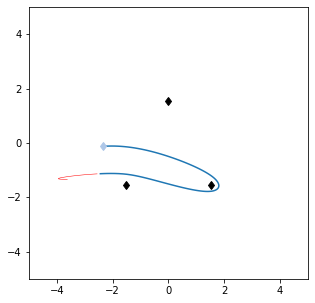

Charges are [-0.47654504 -0.04066623 -0.23762136]


In [207]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [208]:
#todo
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
import torch.nn.functional as F
# import matplotlib as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence


In [209]:
#transfer the coordinate into x1,x2,....y1,y2,....
def datahandling(data):
    result=[]
    for i in range(len(data)):
        a=data[i]
        x=a[:,0]
        y=a[:,1]
        result.append(np.hstack((x,y)))
    return result

In [210]:
#padding all the dataset into the same length   x1,x2,..x110,y1,y2,...y110  (110*2=220)
def create_padding(data):
    result=datahandling(data)
    pad_result=pad_sequence([torch.from_numpy(x) for x in result]).transpose(0,1)
    return pad_result



In [211]:
train_padding_1=create_padding(simulation_train)
valid_padding_1=create_padding(simulation_valid)
test_padding_1=create_padding(simulation_test)


In [212]:
#加载数据集

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data)
        self.targets = torch.tensor(targets)
           
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):  # get the label and data by index
        x = self.data[index]
        y = self.targets[index]
        return x, y

    
train_dataset_1=MyDataset(train_padding_1,charges_train)
valid_dataset_1=MyDataset(valid_padding_1,charges_valid)
test_dataset_1=MyDataset(test_padding_1,charges_valid)
    
# train_dataset_1=MyDataset(simulation_train,charges_train)
# valid_dataset_1=MyDataset(simulation_valid,charges_valid)
# test_dataset_1=MyDataset(simulation_test,charges_test)

C:\Users\15651\AppData\Local\Temp/ipykernel_17084/1325479867.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)


## Model Implementation

In [213]:
#todo
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

In [214]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
input_dim=220
hidden_dim=500
n_layers=2
output_dim=3
drop_prob=0.5


class Mynetwork_1(nn.Module):
    
    def __init__(self, n_input=input_dim, n_hidden=hidden_dim, num_layers=n_layers, n_output=output_dim, drop_prob=drop_prob):
        super(Mynetwork_1, self).__init__()
        
        self.num_layers = num_layers
        self.n_hidden = n_hidden
        self.drop_prob = drop_prob
        self.n_input = n_input
        
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=n_hidden, num_layers=num_layers, dropout=self.drop_prob)
        self.fc = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        # Set initial hidden and cell states 
        x = x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(1), self.n_hidden).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(1), self.n_hidden).to(device) 

        # Forward propagate LSTM
        # input=pack_padded_sequence(x,lengths=length,batch_first=True,enforce_sorted=False)
        out, _ = self.lstm(x,(h0,c0))  
        
        out = self.dropout(out)
        # Decode the hidden state of the last time step
        # out = self.fc(out[:, -1])  # (100, 10)
        
        out = self.fc(out)
        return out

## Model Training

In [215]:

def train1(model, num_epochs, loss_fuc,Batchsize):
    """
    Train the model.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loader_1 = torch.utils.data.DataLoader(train_dataset_1 ,batch_size=Batchsize)
        valid_loader_1 = torch.utils.data.DataLoader(valid_dataset_1 ,batch_size=Batchsize)
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for (features, labels) in train_loader_1:
            # Forward
            (features, labels) = (features.to(device), labels.to(device))
            # print('label:',labels.shape)
            # [100,1,220] 100:batchsize, [1,220] input dim
            # length=length_nonzero(features)
            features = features.float().reshape(-1, 1, 220).to(device)
            labels = labels.float().reshape(-1, 1, 3).to(device)
            # print('feature type:',features.dtype)
            # print('label type:',labels.dtype)
            # print('reshape label:',labels.shape)

            pred = model(features)
            #[100,1,3] 100: batch size [1,3] output dim
            # print('predshape:',pred.shape)
            loss = loss_fuc(pred, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_1)
        train_losses.append(avg_train_loss)

        val_running_loss = 0.0

        # check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for (features, labels) in valid_loader_1:
                (features, labels) = (features.to(device), labels.to(device))
                # length=length_nonzero(features)
                features = features.float().reshape(-1, 1, 220).to(device)
                labels = labels.float().reshape(-1, 1, 3).to(device)
                #labels.float()
                pred = model(features)
                #print(pred)
                loss = loss_fuc(pred, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(valid_loader_1)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
              .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    print("Finished Training")
    return train_losses, val_losses


In [216]:
model1= Mynetwork_1().to(device)
Batchsize=100
epochs=100
Loss= nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
train_losses1,val_losses1=train1(model=model1,num_epochs=epochs,loss_fuc=Loss,Batchsize=Batchsize)

Starting epoch 1
Epoch [1/100],Train Loss: 1.7504, Valid Loss: 0.17623167
Starting epoch 2
Epoch [2/100],Train Loss: 0.1251, Valid Loss: 0.06832485
Starting epoch 3
Epoch [3/100],Train Loss: 0.0916, Valid Loss: 0.06533844
Starting epoch 4
Epoch [4/100],Train Loss: 0.0812, Valid Loss: 0.06829657
Starting epoch 5
Epoch [5/100],Train Loss: 0.0700, Valid Loss: 0.05173795
Starting epoch 6
Epoch [6/100],Train Loss: 0.0593, Valid Loss: 0.04682942
Starting epoch 7
Epoch [7/100],Train Loss: 0.0533, Valid Loss: 0.04963377
Starting epoch 8
Epoch [8/100],Train Loss: 0.0506, Valid Loss: 0.04344605
Starting epoch 9
Epoch [9/100],Train Loss: 0.0466, Valid Loss: 0.04325556
Starting epoch 10
Epoch [10/100],Train Loss: 0.0457, Valid Loss: 0.04440101
Starting epoch 11
Epoch [11/100],Train Loss: 0.0388, Valid Loss: 0.03842678
Starting epoch 12
Epoch [12/100],Train Loss: 0.0387, Valid Loss: 0.03793798
Starting epoch 13
Epoch [13/100],Train Loss: 0.0379, Valid Loss: 0.03744003
Starting epoch 14
Epoch [14/10

In [217]:
def plot_loss(train_loss, val_loss,epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train_loss)
    plt.plot(epoche_range, val_loss)
    plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

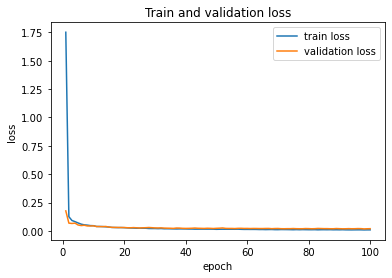

In [218]:
plot_loss(train_loss=train_losses1,val_loss=val_losses1,epoche=epochs)

## Evaluation

In [289]:
def evaluate1(dataset):
    test_feature=dataset.data.reshape(-1,1,220)
    test_label=dataset.targets.reshape(-1,1,3)
    result=model1(test_feature.float())
    test_loss=[]
    for i in range(len(test_label)):
        test_loss.append(Loss(test_label[i],result[i]).tolist())
    return np.mean(test_loss),result,test_label


In [290]:
loss,result,test_label = evaluate1(test_dataset_1)

In [319]:
def evaluate(result,test_label):
    RMSE = []
    mae = []
    for i in range(100):
        x = result[i][0].detach().numpy()
        y = test_label[i][0].detach().numpy()
        mae.append(np.abs(x - y))
        diff = np.subtract(x,y)
        square = np.square(diff)
        RMSE.append(square)
    print('rmse:',sum(sum(RMSE)/len(RMSE))/3)
    print('mae:',sum(sum(mae)/len(mae))/3)
evaluate(result,test_label)

rmse: 0.15157932882161376
mae: 0.3165559577823355


# Task 3.2

## Data Handling and Preprocessing

In [21]:
# we reuse the function we defined before
#feature padding to 220
train_padding_2=create_padding(simulation_train_task32)
valid_padding_2=create_padding(simulation_valid)
test_padding_2=create_padding(simulation_test)

#label  padding the feature into 120
continue_train_padding=create_padding(simulation_continued_train)
continue_valid_padding=create_padding(simulation_continued_valid)
continue_test_padding=create_padding(simulation_continued_test)


train_dataset_2=MyDataset(train_padding_2,continue_train_padding)
valid_dataset_2=MyDataset(valid_padding_2,continue_valid_padding)
test_dataset_2=MyDataset(test_padding_2,continue_test_padding)

C:\Users\15651\AppData\Local\Temp/ipykernel_17084/1325479867.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)
C:\Users\15651\AppData\Local\Temp/ipykernel_17084/1325479867.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets)


## Model Implementation

In [22]:
#todo

In [23]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
input_dim=220
hidden_dim=400  
n_layers=2
output_dim=120
drop_prob=0.5


class Mynetwork_2(nn.Module):
    
    def __init__(self, n_input=input_dim, n_hidden=hidden_dim, num_layers=n_layers, n_output=output_dim, drop_prob=drop_prob):
        super(Mynetwork_2, self).__init__()
        
        self.num_layers = num_layers
        self.n_hidden = n_hidden
        self.drop_prob = drop_prob
        self.n_input = n_input
        
        self.lstm = nn.LSTM(input_size=n_input, hidden_size=n_hidden, num_layers=num_layers, dropout=self.drop_prob)
        self.fc = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        # Set initial hidden and cell states 
        x = x.to(device)
        h0 = torch.zeros(self.num_layers, x.size(1), self.n_hidden).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(1), self.n_hidden).to(device) 

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  
        out = self.dropout(out)
        out = self.fc(out)
        return out

## Model Training

In [24]:
# attention 
def mask(input):
    inputs=input.clone()
    result=[]
    for i in range(len(inputs)):
        index=inputs.data[i].nonzero()
        dataset=inputs.data[i]
        dataset[index]=1
        result.append(dataset)
    return torch.stack(result,0) 

In [26]:

def train2(model, num_epochs, loss_fuc,Batchsize):
    """
    Train the model.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loader_2 = torch.utils.data.DataLoader(train_dataset_2 ,batch_size=Batchsize)
        valid_loader_2 = torch.utils.data.DataLoader(valid_dataset_2 ,batch_size=Batchsize)
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for (features, labels) in train_loader_2:
            # Forward
            (features, labels) = (features.to(device), labels.to(device))
            Mask=mask(labels)
            features = features.reshape(-1, 1, 220).to(device)
            labels = labels.reshape(-1, 1, 120).to(device)
            Mask = Mask.reshape(-1, 1, 120).to(device)
            pred=model2(features.float())
            mask_pred=Mask*pred.float()

            loss = loss_fuc(mask_pred, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader_2)
        train_losses.append(avg_train_loss)

        val_running_loss = 0.0

        # check validation loss after every epoch
        with torch.no_grad():
            model.eval()
            for (features, labels) in valid_loader_2:
                (features, labels) = (features.to(device), labels.to(device))
 
                Mask=mask(labels)

                features = features.reshape(-1, 1, 220).to(device)
                labels = labels.reshape(-1, 1, 120).to(device)
                Mask = Mask.reshape(-1, 1, 120).to(device)
      
                pred=model2(features.float())
                mask_pred=Mask*pred.float()

                loss = loss_fuc(mask_pred, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(valid_loader_2)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
              .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    print("Finished Training")
    return train_losses, val_losses


In [30]:
model2= Mynetwork_2().to(device)
Loss= nn.MSELoss()
epoches=300
# Loss= nn.HuberLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)
train_losses_2,val_losses_2=train2(model=model2,num_epochs=epoches,loss_fuc=Loss,Batchsize=120)

Starting epoch 1
Epoch [1/300],Train Loss: 9.9475, Valid Loss: 12.43447818
Starting epoch 2
Epoch [2/300],Train Loss: 22.2858, Valid Loss: 6.19352669
Starting epoch 3
Epoch [3/300],Train Loss: 8.6077, Valid Loss: 4.70536048
Starting epoch 4
Epoch [4/300],Train Loss: 5.3307, Valid Loss: 3.89313881
Starting epoch 5
Epoch [5/300],Train Loss: 4.2443, Valid Loss: 2.72622367
Starting epoch 6
Epoch [6/300],Train Loss: 3.8228, Valid Loss: 2.50780588
Starting epoch 7
Epoch [7/300],Train Loss: 3.1540, Valid Loss: 2.42404491
Starting epoch 8
Epoch [8/300],Train Loss: 3.7884, Valid Loss: 2.25765897
Starting epoch 9
Epoch [9/300],Train Loss: 3.2836, Valid Loss: 2.32788281
Starting epoch 10
Epoch [10/300],Train Loss: 3.2441, Valid Loss: 2.22231712
Starting epoch 11
Epoch [11/300],Train Loss: 2.7533, Valid Loss: 2.17774229
Starting epoch 12
Epoch [12/300],Train Loss: 2.7972, Valid Loss: 2.13604424
Starting epoch 13
Epoch [13/300],Train Loss: 2.1700, Valid Loss: 2.12009997
Starting epoch 14
Epoch [14/

Epoch [109/300],Train Loss: 0.9780, Valid Loss: 1.88168263
Starting epoch 110
Epoch [110/300],Train Loss: 0.9455, Valid Loss: 1.85558343
Starting epoch 111
Epoch [111/300],Train Loss: 0.8475, Valid Loss: 1.85423250
Starting epoch 112
Epoch [112/300],Train Loss: 0.7960, Valid Loss: 1.88118954
Starting epoch 113
Epoch [113/300],Train Loss: 0.9199, Valid Loss: 1.89731276
Starting epoch 114
Epoch [114/300],Train Loss: 0.9774, Valid Loss: 1.91496153
Starting epoch 115
Epoch [115/300],Train Loss: 0.8169, Valid Loss: 1.90685557
Starting epoch 116
Epoch [116/300],Train Loss: 0.9020, Valid Loss: 1.92477354
Starting epoch 117
Epoch [117/300],Train Loss: 0.7392, Valid Loss: 1.96335630
Starting epoch 118
Epoch [118/300],Train Loss: 0.8128, Valid Loss: 1.95643620
Starting epoch 119
Epoch [119/300],Train Loss: 0.8899, Valid Loss: 1.93546999
Starting epoch 120
Epoch [120/300],Train Loss: 0.8786, Valid Loss: 1.93126081
Starting epoch 121
Epoch [121/300],Train Loss: 0.9504, Valid Loss: 1.92519396
Start

Epoch [215/300],Train Loss: 0.7424, Valid Loss: 1.85667284
Starting epoch 216
Epoch [216/300],Train Loss: 0.8373, Valid Loss: 1.87360605
Starting epoch 217
Epoch [217/300],Train Loss: 0.7788, Valid Loss: 1.89012487
Starting epoch 218
Epoch [218/300],Train Loss: 0.7456, Valid Loss: 1.87010023
Starting epoch 219
Epoch [219/300],Train Loss: 0.7638, Valid Loss: 1.85718675
Starting epoch 220
Epoch [220/300],Train Loss: 0.7065, Valid Loss: 1.84919466
Starting epoch 221
Epoch [221/300],Train Loss: 0.6910, Valid Loss: 1.85559196
Starting epoch 222
Epoch [222/300],Train Loss: 0.6514, Valid Loss: 1.86247774
Starting epoch 223
Epoch [223/300],Train Loss: 0.7420, Valid Loss: 1.87470629
Starting epoch 224
Epoch [224/300],Train Loss: 0.6659, Valid Loss: 1.86418712
Starting epoch 225
Epoch [225/300],Train Loss: 0.7852, Valid Loss: 1.85334023
Starting epoch 226
Epoch [226/300],Train Loss: 0.6822, Valid Loss: 1.85410607
Starting epoch 227
Epoch [227/300],Train Loss: 0.7260, Valid Loss: 1.86340403
Start

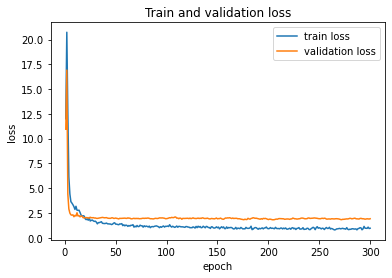

In [106]:
plot_loss(train_loss=train_losses_2,val_loss=val_losses_2,epoche=epoches)

## Evaluation

In [273]:

def evaluate2_with_mask(dataset):
    test_dataset_data=dataset.data
    test_dataset_targets=dataset.targets
    pad = nn.ZeroPad2d(padding=(0,2,0,0))
    pad_targets=pad(test_dataset_targets)
    Mask=mask(pad_targets).reshape(-1,1,120)
    feature=dataset.data.reshape(-1,1,220)
    label=pad_targets.reshape(-1,1,120)
    pred=model2(feature.float())
    mask_pred=Mask*pred
    torch.unsqueeze(mask_pred,0)
    test_loss=[]
    for i in range(len(test_dataset_data)):
        test_loss.append(Loss(label[i],mask_pred[i]).tolist())
    return np.mean(test_loss),mask_pred




In [269]:
def evaluate2_without_mask(dataset):
    test_dataset_data=dataset.data
    test_dataset_targets=dataset.targets
    pad = nn.ZeroPad2d(padding=(0,2,0,0))
    pad_targets=pad(test_dataset_targets)
    feature=dataset.data.reshape(-1,1,220)
    label=pad_targets.reshape(-1,1,120)
    pred=model2(feature.float())
    torch.unsqueeze(pred,0)
    test_loss=[]
    for i in range(len(test_dataset_data)):
        test_loss.append(Loss(label[i],pred[i]).tolist())
    return np.mean(test_loss),pred


In [274]:
test_loss,mask_pred = evaluate2_with_mask(test_dataset_2)
print(test_loss)

1.5272502190783366


In [243]:
test_loss,pred = evaluate2_without_mask(test_dataset_2)
print(test_loss)

2.092748996320609


In [244]:
def plot_pre(index,dataset,pred):
    train_list=[]
    for i in dataset.data[index].detach().numpy():
        if i !=0 :
            train_list.append(i)
    train_array= np.zeros([int(len(train_list)/2),2], dtype = float)
    for i in range(int(len(train_list)/2)):
        train_array[i] = [train_list[i],train_list[i+int(len(train_list)/2)]] 

    continous_list = list(pred.detach().numpy()[index][0])
    continous_array= np.zeros([int(len(continous_list)/2),2], dtype = float)
    for i in range(int(len(continous_list)/2)):
        continous_array[i] = [continous_list[i],continous_list[i+int(len(continous_list)/2)]] 
        
    plot_example(train_array, continous_array)

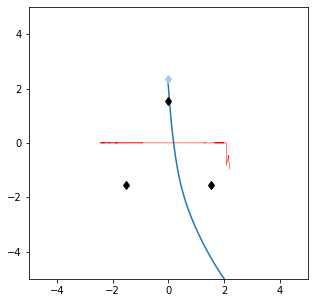

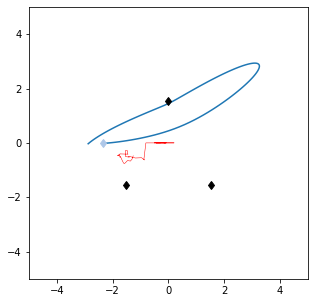

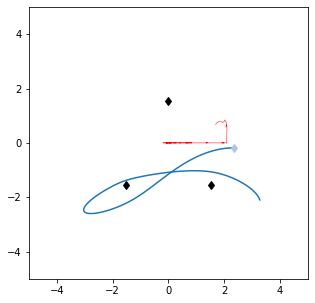

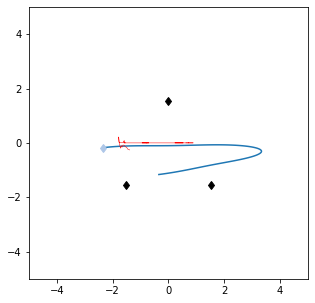

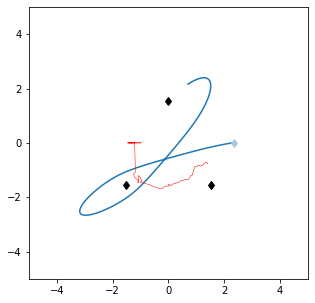

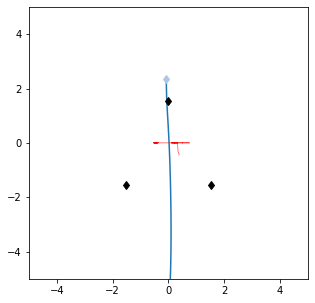

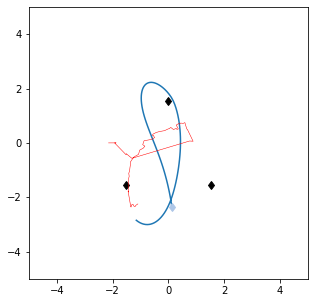

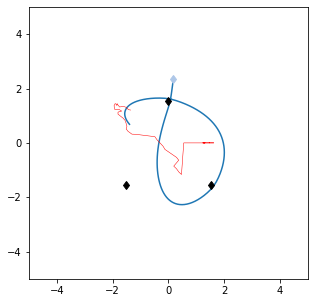

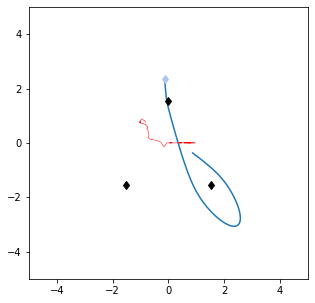

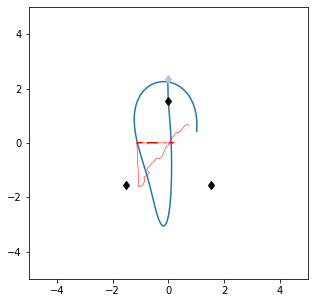

In [320]:
for i in range(10):
    plot_pre(random.randint(0,99),test_dataset_2,mask_pred)

In [314]:
def cosine_similarity(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

def evaluate(test_dataset_2,pred):
    similarity = []
    RMSE = []
    for i in range(100):
        x = np.delete(pred[i][0].detach().numpy(), 119)
        x = np.delete(x,118)
        y = test_dataset_2.targets[i].detach().numpy()
        similarity.append(cosine_similarity(x,y))
        diff = np.subtract(x,y)
        square = np.square(diff)
        RMSE.append(np.sqrt(square))
    res = list(map(abs,similarity))
    print('rmse:',sum(sum(RMSE)/len(RMSE))/100)
    print('similarity:',sum(res)/len(res))

In [315]:
evaluate(test_dataset_2,mask_pred)


rmse: 0.9322418255589944
similarity: 0.518954784907589


In [316]:
evaluate(test_dataset_2,pred)

rmse: 1.3328450080968486
similarity: 0.38761215764318097
